<a href="https://colab.research.google.com/github/syedsaifhasan/Sentiment-Analysis/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install pytreebank

In [3]:
# Importing Libraries
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, GRU
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM
import pytreebank
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

glove_twitter = 'glove.twitter.27B.200d.txt'
glove_crawl = 'glove.42B.300d.txt'
fasttext = 'fasttext-wiki-news-300d-1M.vec'
fasttext_subword = 'fasttext-wiki-news-300d-1M-subword.vec'


pre_trained_model = fasttext_subword

In [5]:
print('Processing text dataset')

dataset = pytreebank.load_sst()
texts = []  # list of text samples
labels = []  # list of label ids

for key in ['train', 'test', 'dev']:
    exampleDataset = dataset[key]
    print (len(exampleDataset))
    for example in exampleDataset:
        label, sentence = example.to_labeled_lines()[0]
        texts.append(sentence)
        labels.append(label)

test_labels = labels[8544:8544+2210]

Processing text dataset
8544
2210
1101


In [6]:
print ("Complete Length of Dataset: ", len(texts))

x_train = texts[:8544]
y_train = labels[:8544]

x_test = texts[8545:8545+2210]
y_test = labels[8545:8545+2210]

x_val = texts[-1101:]
y_val = labels[-1101:]

print ('\nLength of Training Data: ', len(x_train))
print ('Length of Testing Data: ', len(x_test))
print ('Length of Validation Data: ', len(x_val))

Complete Length of Dataset:  11855

Length of Training Data:  8544
Length of Testing Data:  2210
Length of Validation Data:  1101


In [7]:
def encode(data, labels, tokenizer=None):
  # Encode Text
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data)
  sequences = tokenizer.texts_to_sequences(data)
  data = pad_sequences(sequences, maxlen=50)
  # Encode Labels
  labels = to_categorical(np.asarray(labels))
  # Create Dictsizeionary
  dictionary = tokenizer.word_index
  return data, labels, dictionary

# FETCH DATA, LABELS, DICTIONARIES
x_train, y_train, train_dictionary = encode(x_train, y_train)
x_val, y_val, validation_dictionary = encode(x_val, y_val)
x_test, y_test, test_dictionary = encode(x_test, y_test)

actual = test_labels

print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)
print (x_val.shape, y_val.shape)

print ("Data Encoded...\n")

print ("Dictionaries Loaded...")
print ('Training Dictionary: {} Words'.format(len(train_dictionary)))
print ('Validation Dictionary: {} Words'.format(len(validation_dictionary)))
print ('Testing Dictionary: {} Words'.format(len(test_dictionary)))

(8544, 50) (8544, 5)
(2210, 50) (2210, 5)
(1101, 50) (1101, 5)
Data Encoded...

Dictionaries Loaded...
Training Dictionary: 15333 Words
Validation Dictionary: 4950 Words
Testing Dictionary: 7676 Words


In [8]:
print('Preparing embedding matrix.')

embeddings_index = {}
with open('/content/drive/My Drive/sentiment_classification/' + pre_trained_model) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Preparing embedding matrix.
Found 999995 word vectors.


In [9]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(train_dictionary) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in train_dictionary.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print ('Emedding Matrix created of Shape: ', embedding_matrix.shape)

Emedding Matrix created of Shape:  (15334, 300)


In [10]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=50,
                            trainable=False)

print('Training model.')

print('Build model...')
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(300, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(5, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Training model.
Build model...



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4600200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
Total params: 5,322,905
Trainable params: 722,705
Non-trainable params: 4,600,200
_________________________________________________________________


In [11]:
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_val, y_val))

print ('Evaluating Model...')
score, acc = model.evaluate(x_test, y_test,
                            batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8544 samples, validate on 1101 samples
Epoch 1/25





8544/8544 [==============================] - 10s 1ms/step - loss: 1.5674 - acc: 0.2836 - val_loss: 1.5669 - val_acc: 0.2916
Epoch 2/25
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5368 - acc: 0.3234 - val_loss: 1.5536 - val_acc: 0.3034
Epoch 3/25
8544/8544 [==============================] - 9s 1000us/step - loss: 1.4976 - acc: 0.3427 - val_loss: 1.5544 - val_acc: 0.2925
Epoch 4/25
8544/8544 [==============================] - 8s 992us/step - loss: 1.4780 - acc: 0.3551 - val_loss: 1.5572 - val_acc: 0.2961
Epoch 5/25
8544/8544 [==============================] - 8s 980us/step - loss: 1.4633 - acc: 0.3597 - val_loss: 1.5588 - val_acc: 0.2925
Epoch 6/25
8544/8544 [==============================] - 8s 989us/step - loss: 1.4450 - acc: 0.3711 - val_loss: 1.5702 - val_acc: 0.2843
Epoch 7/25
8544/8544 [=====

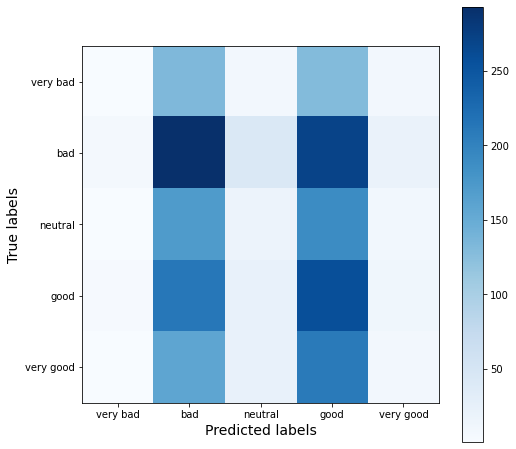

In [12]:
#Confusion Matrix and Classification Report
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)

target_names = ('very bad', 'bad', 'neutral', 'good', 'very good')

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels", fontsize=14)
plt.ylabel("True labels", fontsize=14)
plt.xticks(np.arange(5), target_names, fontsize=10)
plt.yticks(np.arange(5), target_names, fontsize=10)
plt.colorbar()
plt.show()

In [13]:
# Print f1, precision, and recall scores
print(precision_score(test_labels, y_pred , average="macro"))
print(recall_score(test_labels, y_pred , average="macro"))
print(f1_score(test_labels, y_pred , average="macro"))

0.18214998152512565
0.20721874092067116
0.16095351323815155


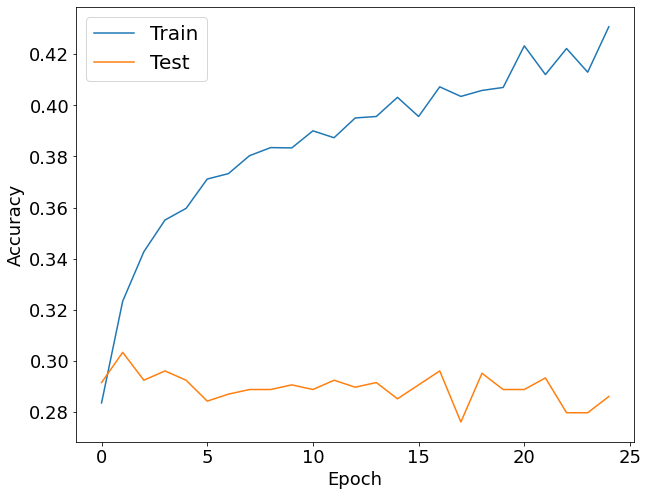

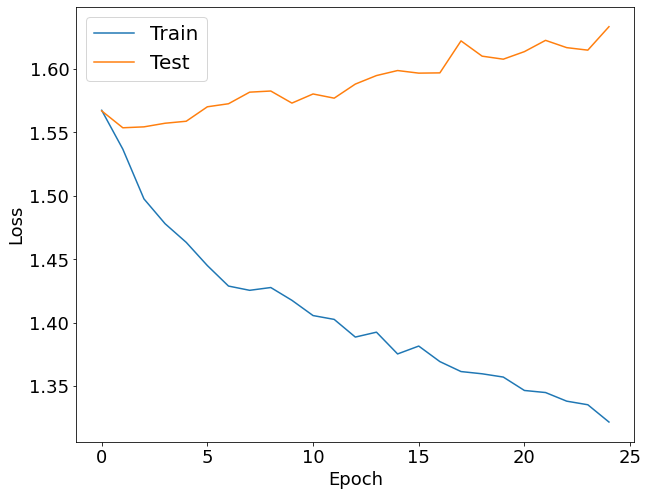

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()